In [377]:
import math as ma
import yfinance as yf
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_ta as ta
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

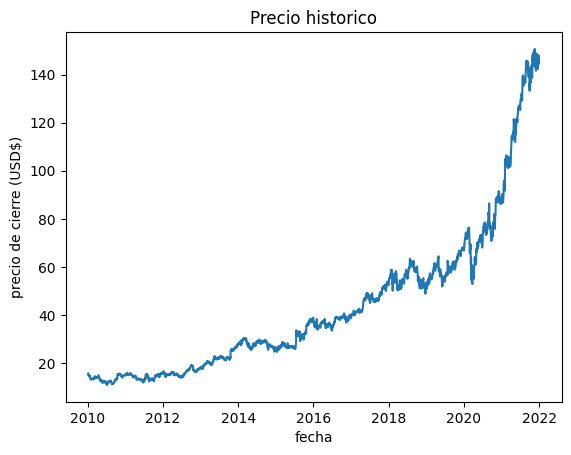

(323, 5)
(323, 5)


In [378]:
#var de testeo
stride = 30
simbolo = "Goog"
#conseguir la data
#dfTrain = web.DataReader('SYP', 'stooq', dt.datetime(2020,1,1), dt.datetime(2023,1,1))
dfTrain = yf.download(tickers= simbolo, start= dt.datetime(2010,1,1), end= dt.datetime(2022,1,1))
dfTest =  yf.download(simbolo, start = dt.datetime(2022,1,1),end = dt.datetime(2023,11,17)) #dt.date.today())

dataTrain = dfTrain.filter(['Close'])
grafData = dataTrain.copy()
#agrego indicadores: 
dataTrain['RSI']=ta.rsi(dataTrain['Close'], length=15)
dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)
dataTrain.dropna(inplace=True)
#dataTrain.reset_index(inplace = True)
#agrego indicadores para test: 
dataTest = dfTest.filter(['Close'])

dataTest['RSI']=ta.rsi(dataTest['Close'], length=15)
dataTest['EMAF']=ta.ema(dataTest['Close'], length=20)
dataTest['EMAM']=ta.ema(dataTest['Close'], length=100)
dataTest['EMAS']=ta.ema(dataTest['Close'], length=150)

dataTestAux = dataTest['Close'][:149]
dataTest.dropna(inplace=True)




plt.title('Precio historico')
plt.plot(grafData)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()


# print((dataTrain['Close'][0] - min(dataTrain['Close']))/(max(dataTrain['Close'])-min(dataTrain['Close'])))
# print(dataTrain)

dataTrain =dataTrain.values 
dataTest = dataTest.values


# dataTrain = np.flip(dataTrain)
dataTest = np.flip(dataTest)

print((dataTest.shape))
dataTest2 = dataTest[(323-stride):,:].copy()
#dataTest = dataTest[:323,:]
print((dataTest.shape))


In [379]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)


# print(dataNormTrain[0:stride+1,:])
# print(dataNormTrain[stride,:])
# print(dataNormTrain)
# print(dataNormTest)

# print(dataNormTest[0:stride+1,:])
# print(dataNormTest[stride,:])

In [380]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []


for i in range(stride, len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i, :])
    y_train.append(dataNormTrain[i,4])
    # if i<=stride:
    #     print(x_train)
    #     print(y_train)


# print(x_train[3], y_train[:3])

# for i in range(len(x_train)):
#     print(x_train[i], y_train[i]) 

#yi = np.array(dataNormTrain[stride:,-1])
#y=np.reshape(yi,(len(yi),1))

# for i in range(stride,len(dataNormTrain)):
#     x_train.append(dataNormTrain[i-stride:i,0])
#     y_train.append(dataNormTrain[i,0])




In [381]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
#el modelo necesita el numero de samples, de datos y de features
#x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1] ,1))

In [382]:
#construir la red LSTM #!aprender que hace esto bien (o buscar el codigo pelado)

# print(x_train.shape)
lstm_input = Input(shape=(stride, x_train.shape[2]), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
#inputs = LSTM(50, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=x_train, y=y_train, epochs=50, batch_size=stride, shuffle=True, validation_split = 0.1) 

Epoch 1/50
86/86 [==============================] - 4s 25ms/step - loss: 0.0022 - val_loss: 6.3455e-04
Epoch 2/50
86/86 [==============================] - 2s 21ms/step - loss: 3.2699e-05 - val_loss: 5.8414e-04
Epoch 3/50
86/86 [==============================] - 2s 22ms/step - loss: 2.4177e-05 - val_loss: 2.7050e-04
Epoch 4/50
86/86 [==============================] - 2s 20ms/step - loss: 1.7308e-05 - val_loss: 2.4214e-04
Epoch 5/50
86/86 [==============================] - 2s 19ms/step - loss: 1.2058e-05 - val_loss: 2.1486e-04
Epoch 6/50
86/86 [==============================] - 2s 19ms/step - loss: 8.0476e-06 - val_loss: 2.0109e-04
Epoch 7/50
86/86 [==============================] - 2s 19ms/step - loss: 5.2945e-06 - val_loss: 1.9214e-04
Epoch 8/50
86/86 [==============================] - 2s 20ms/step - loss: 2.5986e-06 - val_loss: 3.8417e-04
Epoch 9/50
86/86 [==============================] - 2s 20ms/step - loss: 1.7434e-06 - val_loss: 3.6090e-04
Epoch 10/50
86/86 [======================

In [383]:
# print(dataNormTrain[-stride:,4])
# print(dataNormTest[:10,4])

In [384]:
#crea datos para test
#separa en X y en Y 

testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 

#print(testData.shape)
x_test = []
y_test = dataTest[:,4]

# print(len(dataTest))

for i in range(stride, len(testData)): 
     x_test.append(testData[i-stride:i,:])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)

#x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2]))
# print(x_test[-1])
# print(y_test[-2])


In [385]:
#print(model.predict(x_test[:-30]))

In [386]:
#prediccion del modelo para test
prediccion = np.zeros((x_test.shape[0],5))
aux = model.predict(x_test)
aux = np.reshape(aux,(aux.shape[0]))
#print(aux)
prediccion[:,-1] = aux[:]
prediccion = scaler.inverse_transform(prediccion)
prediccion = prediccion[:,-1]
print(prediccion.shape[0])

11/11 [==============================] - 1s 8ms/step
323


In [387]:
print(prediccion[:35])
print(y_test[:35])

[140.0952439 139.1795784 137.6899358 136.0589041 134.2620505 132.6335550
 130.8688783 129.4752530 128.1909891 126.9660517 125.7619595 124.4613712
 123.1508495 121.6502360 120.3279698 118.8340214 117.4962565 116.6460239
 117.7639871 118.9033750 119.9194954 121.2811380 122.6469233 124.2079630
 125.5802330 126.5218371 127.5585599 128.7113161 129.4264811 130.0149923
 130.3760028 130.2547997 130.0540945 129.3862582 128.9497738]
[138.6999969 136.3800049 135.4299927 133.6399994 134.0599976 131.6900024
 133.2599945 132.3999939 131.4499969 130.3699951 128.5800018 127.5699997
 125.3000031 125.7500000 123.4000015 123.4400024 126.6699982 140.1199951
 137.8999939 136.7400055 138.9799957 139.2799988 140.9900055 140.4900055
 138.5800018 140.2899933 141.6999969 139.1999969 139.5000000 138.7299957
 135.9900055 136.2700043 133.3000031 135.1699982 131.8500061]


In [388]:
#calcular error del modelo (RMSE)
#!chequear que el error este bien
print(len(prediccion))
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print("{:.2f}".format(rmse))


323
7.27


In [389]:
prediccion = np.flip(prediccion)

In [390]:
#Arma las estructuras para  graficar
train = dfTrain
valid = dfTest
prediccion = np.concatenate((dataTestAux[:], prediccion[:]))

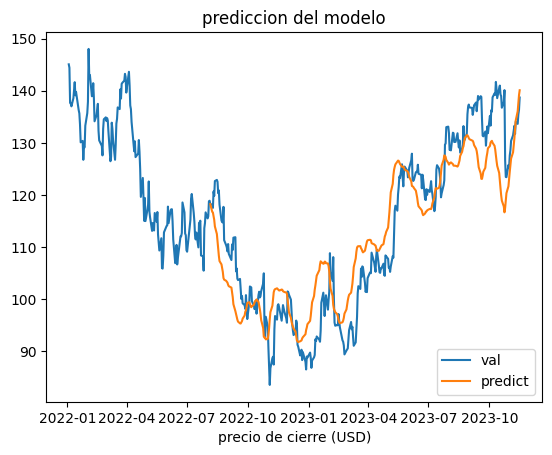

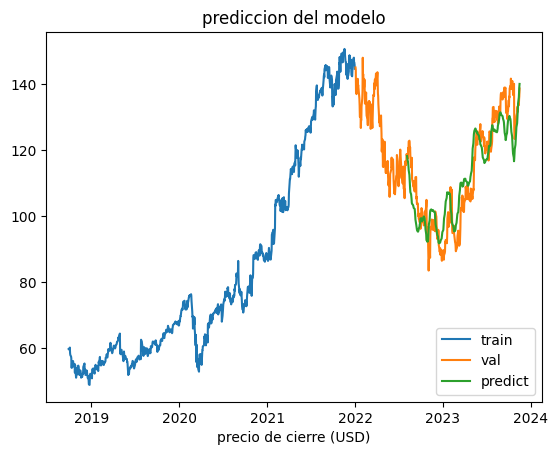

In [391]:

#testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
valid['Predictions'] = prediccion

#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
#plt.plot(train['Close'][2000:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][148:])
plt.legend(['val', 'predict'], loc = 'lower right')
plt.figure()


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'][2200:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][148:])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [392]:
#imprimir los valores
print(valid[['Close', 'Predictions']][148:])

                 Close  Predictions
Date                               
2022-08-05  118.220001   118.220001
2022-08-08  118.139999   116.742399
2022-08-09  117.500000   116.613285
2022-08-10  120.650002   115.957384
2022-08-11  119.820000   115.203759
...                ...          ...
2023-11-10  134.059998   134.262050
2023-11-13  133.639999   136.058904
2023-11-14  135.429993   137.689936
2023-11-15  136.380005   139.179578
2023-11-16  138.699997   140.095244

[324 rows x 2 columns]


In [393]:
#simulacion de trading 

print(dataTest2)

[[120.8925985 116.5360103 109.3781264 35.5746263 103.8499985]
 [121.1213582 116.7922933 109.9600346 35.0162323 103.6299973]
 [121.3561416 117.0581983 110.6263543 35.3673630 103.9000015]
 [121.5904522 117.3240205 111.3343915 37.9594654 105.8700027]
 [121.8014649 117.5554148 111.9095903 36.7291528 105.3099976]
 [122.0228269 117.8027969 112.6042843 46.8971458 111.8700027]
 [122.1591064 117.9226513 112.6815771 46.7082255 111.7799988]
 [122.2984233 118.0467453 112.7764800 41.6258250 109.4199982]
 [122.4712880 118.2210231 113.1297939 43.3593251 110.4800034]
 [122.6322449 118.3774073 113.4087192 36.3584595 107.4800034]
 [122.8356307 118.5975569 114.0327946 38.1173622 108.6800003]
 [123.0256391 118.7979115 114.5962466 41.0023500 110.5500031]
 [123.1930973 118.9645360 115.0221670 37.7079462 109.1500015]
 [123.3815953 119.1628094 115.6402897 38.8058450 109.9100037]
 [123.5624220 119.3497348 116.2434777 39.4117977 110.3399963]
 [123.7399042 119.5317497 116.8648968 40.7373106 111.3000031]
 [123.90